### 1. Data Preparation

In [1]:
#import necessity libraries

from pyspark import SparkConf,SparkContext
from pyspark.sql import SparkSession
from py4j.java_gateway import java_import
import spark
import pyspark.sql.types as t
import pyspark.sql.functions as f
from pyspark.sql.functions import *

import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np

### 2. Create Spark DataFrame

In [2]:
# Create a Spark Context
sc = SparkContext.getOrCreate()
sc.setLogLevel("WARN")
sc.setLogLevel("ERROR")

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Import the necessary Java classes
java_import(spark._jvm, 'org.apache.hadoop.fs.Path')
java_import(spark._jvm, 'org.apache.hadoop.fs.FileSystem')

# Specify the path to the CSV file - name of the CSV file
file_path = 'listenings.csv'

# Get the Hadoop FileSystem object
fs = spark._jvm.FileSystem.get(spark._jsc.hadoopConfiguration())

# Create a Path object
path = spark._jvm.Path(file_path)

# Check if the file exists
if fs.exists(path):
    # Get the FileStatus object
    file_status = fs.getFileStatus(path)

    # Get the file size in bytes
    file_size = file_status.getLen()

    # Convert the file size to gigabytes
    file_size_gb = file_size / (1024**3)

    # Print the file size in GBs
    print(f"The file size of '{file_path}' is: {file_size_gb:.2f} GB")
else:
    print(f"The file '{file_path}' does not exist.")


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/17 15:55:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


The file size of 'listenings.csv' is: 1.01 GB


In [3]:
#reading the csv file
listening_df = spark.read.format('csv').option('inferSchema',True).option('header',True).load('listenings.csv')

In [4]:
#Shows the first 20 rows
listening_df.show()

+-----------+-------------+--------------------+---------------+--------------------+
|    user_id|         date|               track|         artist|               album|
+-----------+-------------+--------------------+---------------+--------------------+
|000Silenced|1299680100000|           Price Tag|       Jessie J|         Who You Are|
|000Silenced|1299679920000|Price Tag (Acoust...|       Jessie J|           Price Tag|
|000Silenced|1299679440000|Be Mine! (Ballad ...|          Robyn|            Be Mine!|
|000Silenced|1299679200000|            Acapella|          Kelis|            Acapella|
|000Silenced|1299675660000|   I'm Not Invisible|      The Tease|   I'm Not Invisible|
|000Silenced|1297511400000|Bounce (Feat NORE...|       MSTRKRFT|         Fist of God|
|000Silenced|1294498440000|Don't Stop The Mu...|        Rihanna|Addicted 2 Bassli...|
|000Silenced|1292438340000|               ObZen|      Meshuggah|               ObZen|
|000Silenced|1292437740000|   Yama's Messengers|      

- Show the schema all the attributes

In [5]:
listening_df.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- date: long (nullable = true)
 |-- track: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- album: string (nullable = true)



- Show the deescribe for the attributes in the columns


In [6]:
listening_df.describe().show()

+-------+------------------+--------------------+---------+--------------------+--------+
|summary|           user_id|                date|    track|              artist|   album|
+-------+------------------+--------------------+---------+--------------------+--------+
|  count|          14650594|            14650594| 14650364|            14650159|13759457|
|   mean|2438208.8012805856|1.384526618053161E12|      NaN|            Infinity|Infinity|
| stddev|  5844371.34494618|8.346146043840077E10|      NaN|                 NaN|     NaN|
|    min|            --Seph|                   0|         |                    |        |
|    max|           zzzzita|       1460547615000|�� ��k  �|￼Frankie & The He...|    💧💧|
+-------+------------------+--------------------+---------+--------------------+--------+



- Show the NaN in each of the column

In [7]:
listening_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in listening_df.columns]).show()

+-------+----+-----+------+------+
|user_id|date|track|artist| album|
+-------+----+-----+------+------+
|      0|   0|  235|   435|891137|
+-------+----+-----+------+------+



- Drop the rows that has NaN and drop the Duplicates

In [8]:
listening_df = listening_df.na.drop(how='any')
listening_df = listening_df.dropDuplicates()

In [9]:
#double check again if the null/NaN values have been deleted or not
listening_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in listening_df.columns]).show()

+-------+----+-----+------+-----+
|user_id|date|track|artist|album|
+-------+----+-----+------+-----+
|      0|   0|    4|     0|    0|
+-------+----+-----+------+-----+



- Drop the unnecessary data

In [10]:
listening_df = listening_df.drop('date')

In [11]:
listening_df.show()

+---------------+--------------------+--------------------+--------------------+
|        user_id|               track|              artist|               album|
+---------------+--------------------+--------------------+--------------------+
|beast_of_burden|#285 Trance Aroun...|      Above & Beyond|Above & Beyond: T...|
|     BrigBother|   #543: Wake Up Now|Chicago Public Media|  This American Life|
|  burntheaction|          #thatPOWER|             william|          #thatPOWER|
|          beggz|             '74-'75|        The Connells|                Ring|
|      Adam_john|                'Hey| It's Your Funera...|        Alexisonfire|
|        anuragT|               (-_-)|       Adebisi Shank|This is the secon...|
| Brand_New_Hero|(Aquatic Cupid's)...|Thunderbirds Are ...|       Justamustache|
|        adams87|     (Cant Be) Fixed|          Spineshank|The Height Of Cal...|
|       buckbeak|(Don't Fear) The ...|    Blue Öyster Cult|The Essential Blu...|
|         Akuzed|(Don't Fear

#### Exploratory Data Analyst

### Q1. Find distinct value in the 'user_id' column

In [12]:
listening_df.select(f.countDistinct('user_id')).first()[0]

74176

- Check the shape of the dataset

In [13]:
shape = (listening_df.count(), len(listening_df.columns))
print(shape)

(9981664, 4)


### ---------------------------- Create the Template View - called 'utilization' ----------------------------

In [14]:
listening_df.createOrReplaceTempView("utilization")

### Q2: Select only 2 columns: tracks and artist

In [15]:
### Select the expected columns
q2 = listening_df.select('artist','track') #SQL -> "Select artist, track from ultilization"

In [16]:
q2.show()

+--------------------+--------------------+
|              artist|               track|
+--------------------+--------------------+
|      Above & Beyond|#285 Trance Aroun...|
|Chicago Public Media|   #543: Wake Up Now|
|             william|          #thatPOWER|
|        The Connells|             '74-'75|
| It's Your Funera...|                'Hey|
|       Adebisi Shank|               (-_-)|
|Thunderbirds Are ...|(Aquatic Cupid's)...|
|          Spineshank|     (Cant Be) Fixed|
|    Blue Öyster Cult|(Don't Fear) The ...|
|    Blue Öyster Cult|(Don't Fear) The ...|
|Noel Gallagher's ...|(I Wanna Live in ...|
|Alan Menken / Dav...|(I Won't Say) I'm...|
|           Peggy Sue|(Love Is Like A) ...|
|                DIIV|              (Napa)|
|        Shania Twain|(Wanna Get To Kno...|
| Love And Underst...|(What's So Funny ...|
|       Elvis Presley|(You're The) Devi...|
|       Jackie Wilson|(Your Love Keeps ...|
|           Kurt Vile|    (so outta reach)|
|                Mika|01 - Mika 

### Q3. Lets find all the records of those users who have listend to Rihanna

In [17]:
'''
SELECT * 
FROM utilization 
WHERE artist == 'Rihanna'
'''
q3 = listening_df.select('*').filter(listening_df.artist == 'Rihanna')
#q3 = listening_df.select('*').filter((listening_df.artist == 'Rihanna') & (listening_df.album == 'Loud')).select('user_id','track')

In [18]:
q3.show()

+--------------+--------------------+-------+--------------------+
|       user_id|               track| artist|               album|
+--------------+--------------------+-------+--------------------+
|   000Silenced|           Disturbia|Rihanna|Good Girl Gone Ba...|
|AaliyahCarmela| Where Have You Been|Rihanna|Talk That Talk (D...|
|        abbiii|   Shut Up and Drive|Rihanna|  Good Girl Gone Bad|
|     AdamBell1|Stay (feat Mikky ...|Rihanna|Unapologetic (Del...|
|          adxx|   Same Ol’ Mistakes|Rihanna|                ANTI|
|       adzee10|                Work|Rihanna|       ANTI (Deluxe)|
|       Afromob|         Sex With Me|Rihanna|       ANTI (Deluxe)|
|  alittlevoice| California King Bed|Rihanna|                Loud|
|         amyrb|       Drunk on Love|Rihanna|Talk That Talk (D...|
|ascendingstars|       Birthday Cake|Rihanna|Talk That Talk (E...|
|      ashley84|      Wait Your Turn|Rihanna|             Rated R|
|       auxbuss|Only Girl (In the...|Rihanna|       Loud (delu

In [19]:
#to see all the values -> in pandas this will be q1.unique()
#q1.select('user_id').distinct().rdd.flatMap(lambda x: x).collect()
q3.select('user_id').distinct().limit(10).rdd.flatMap(lambda x: x).collect()

['BolaJA',
 'abbyquinlan',
 'abiprincess',
 'AndrewTerry',
 'aaronspud',
 'adamnmcc',
 'agentgypo',
 'Bauldrick',
 'boardy2',
 'booksfromboxes_']

### Q4: Lets find top 10 users who are fan of Rihanna

In [20]:
'''spark.sql("""
    SELECT user_id, COUNT(user_id) AS count
    FROM utilization
    WHERE artist = 'Rihanna'
    GROUP BY user_id
    ORDER BY count DESC
    LIMIT 10
""").show()'''
q4 = listening_df.select('user_id').filter(listening_df.artist == 'Rihanna').groupby('user_id').agg(count('user_id').alias('count')).orderBy(desc('count')).limit(10)
q4.show()

+--------------+-----+
|       user_id|count|
+--------------+-----+
|        iSkank|   62|
|        folano|   53|
|FrenchyEchelon|   52|
|    BIGBANG186|   51|
|       meeshii|   48|
|Pinky_von_Pout|   47|
| LisaGardner92|   46|
|  FelineWonder|   44|
| mikedennis_75|   43|
|        warleh|   42|
+--------------+-----+



<BarContainer object of 10 artists>

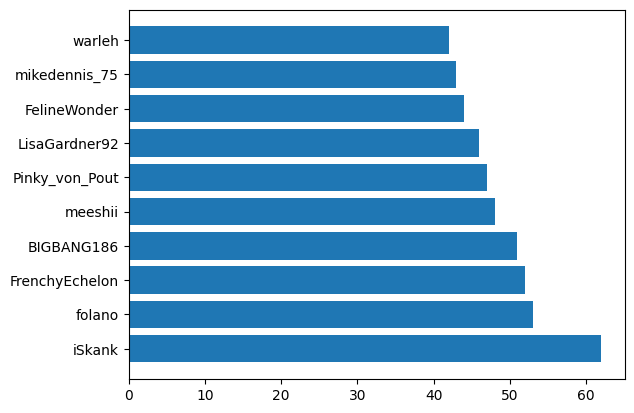

In [21]:
#plot the bar charts to shows the top 10 fans of Rihanna
plt.barh(q4.toPandas()['user_id'],q4.toPandas()['count'])

### Q5. Find top 10 famous track

In [22]:
q5 = listening_df.select('artist','track').groupBy('artist','track').agg(count('*').alias('count')).orderBy(desc('count')).limit(10)

In [23]:
#SQL Spark
spark.sql("""
    SELECT artist, track, COUNT(*) AS count
    FROM utilization
    GROUP BY artist, track
    ORDER BY count DESC
    LIMIT 10
""").show()

+--------------------+--------------------+-----+
|              artist|               track|count|
+--------------------+--------------------+-----+
|         The Killers|       Mr Brightside| 1828|
|            Bon Iver|         Skinny Love| 1794|
|       Fleetwood Mac|     Go Your Own Way| 1624|
|       Justin Bieber|               Sorry| 1584|
|Florence + the Ma...|   Dog Days Are Over| 1546|
|      Arctic Monkeys|    Do I Wanna Know?| 1514|
|      Arctic Monkeys|I Bet You Look Go...| 1502|
|      Mumford & Sons|     Little Lion Man| 1460|
|      Mumford & Sons|            The Cave| 1454|
|           blink-182|All the Small Things| 1436|
+--------------------+--------------------+-----+



In [24]:
q5.show()

+--------------------+--------------------+-----+
|              artist|               track|count|
+--------------------+--------------------+-----+
|         The Killers|       Mr Brightside| 1828|
|            Bon Iver|         Skinny Love| 1794|
|       Fleetwood Mac|     Go Your Own Way| 1624|
|       Justin Bieber|               Sorry| 1584|
|Florence + the Ma...|   Dog Days Are Over| 1546|
|      Arctic Monkeys|    Do I Wanna Know?| 1514|
|      Arctic Monkeys|I Bet You Look Go...| 1502|
|      Mumford & Sons|     Little Lion Man| 1460|
|      Mumford & Sons|            The Cave| 1454|
|           blink-182|All the Small Things| 1436|
+--------------------+--------------------+-----+



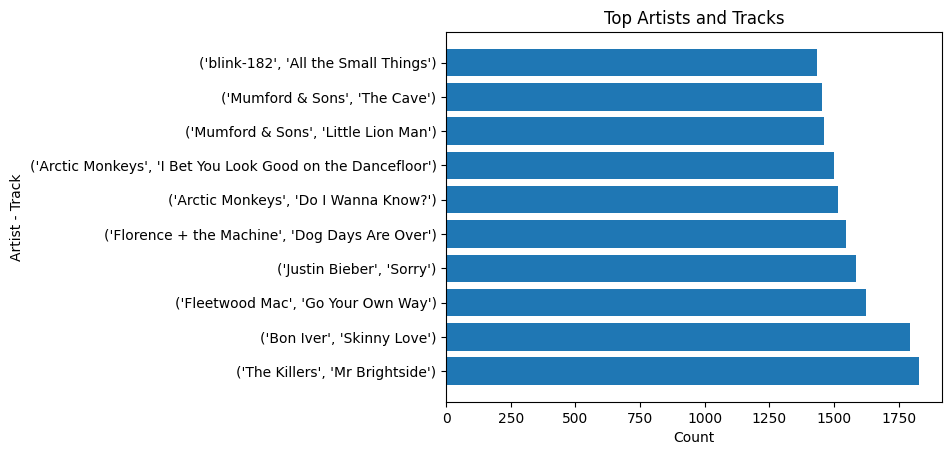

In [25]:
# Get the data from the DataFrame
a1 = q5.select('artist').toPandas()['artist']
a2 = q5.select('track').toPandas()['track']
a3 = q5.select('count').toPandas()['count']

# Create a horizontal bar chart
plt.barh(range(len(a1)), a3)

# Customize the chart
plt.yticks(range(len(a1)), zip(a1, a2))
plt.xlabel('Count')
plt.ylabel('Artist - Track')
plt.title('Top Artists and Tracks')

# Display the chart
plt.show()

### Q6. Find top 10 famous track of Rihanna

In [26]:
q6 = listening_df.select('artist','track').filter(listening_df.artist == 'Rihanna').groupBy('artist','track').agg(count('*').alias('count')).orderBy(desc('count')).limit(10)

In [27]:
#SQL Spark
spark.sql("""
    SELECT artist, track, COUNT(*) AS count
    FROM utilization
    where artist == 'Rihanna'
    GROUP BY artist, track
    ORDER BY count DESC
    LIMIT 10
""").show()

+-------+--------------------+-----+
| artist|               track|count|
+-------+--------------------+-----+
|Rihanna|                Work| 1151|
|Rihanna|Only Girl (In the...|  866|
|Rihanna|We Found Love (fe...|  797|
|Rihanna|            Rude Boy|  751|
|Rihanna|                 S&M|  738|
|Rihanna|            Diamonds|  612|
|Rihanna| Where Have You Been|  493|
|Rihanna|           Disturbia|  443|
|Rihanna|            Umbrella|  409|
|Rihanna|      Kiss it Better|  389|
+-------+--------------------+-----+



In [28]:
q6.show() 

+-------+--------------------+-----+
| artist|               track|count|
+-------+--------------------+-----+
|Rihanna|                Work| 1151|
|Rihanna|Only Girl (In the...|  866|
|Rihanna|We Found Love (fe...|  797|
|Rihanna|            Rude Boy|  751|
|Rihanna|                 S&M|  738|
|Rihanna|            Diamonds|  612|
|Rihanna| Where Have You Been|  493|
|Rihanna|           Disturbia|  443|
|Rihanna|            Umbrella|  409|
|Rihanna|      Kiss it Better|  389|
+-------+--------------------+-----+



### Q7. Find top 10 famous album

In [29]:
q7 = listening_df.select('artist','album').groupBy('artist','album').agg(count('*').alias('count')).orderBy(desc('count')).limit(10)

In [30]:
q7.show()

+--------------------+--------------------+-----+
|              artist|               album|count|
+--------------------+--------------------+-----+
|          Kanye West|   The Life Of Pablo|11428|
|      Arctic Monkeys|Whatever People S...| 9232|
|              The xx|                  xx| 8928|
|      Mumford & Sons|        Sigh No More| 8474|
|            Bon Iver|            For Emma| 8293|
|               alt-J|     An Awesome Wave| 8216|
|      Arctic Monkeys|                  AM| 7954|
|Florence + the Ma...|               Lungs| 7523|
|         Arcade Fire|         The Suburbs| 6823|
|               Adele|                  21| 6757|
+--------------------+--------------------+-----+



### Reading the new 'genres.csv' file

In [31]:
genre_df = spark.read.format('csv').option('inferSchema',True).option('header',True).load('genre.csv')

In [32]:
genre_df.show()

+--------------------+-----+
|              artist|genre|
+--------------------+-----+
|                Muse| rock|
|             Nirvana| rock|
|            Bon Jovi| rock|
|          The Police| rock|
|                Kiss| rock|
|       Guns N' Roses| rock|
|         Rusted Root| rock|
|Katrina and the W...|  pop|
|         The Beatles| rock|
|        Hall & Oates|  pop|
|        Otis Redding| soul|
|         Marvin Gaye| soul|
|     The Cranberries| rock|
|            Survivor| rock|
|       Fleetwood Mac|blues|
|           Radiohead| rock|
|                Toto| rock|
|                  U2| rock|
|Creedence Clearwa...| rock|
|                 REM| rock|
+--------------------+-----+
only showing top 20 rows



In [33]:
genre_df.describe().show()

+-------+------------------+------------------+
|summary|            artist|             genre|
+-------+------------------+------------------+
|  count|            138432|            138415|
|   mean|          Infinity|1.6666666666666667|
| stddev|               NaN|1.5275252316519468|
|    min| Sydney Youngblood|                  |
|    max|        ｍｏｃｈＡ|            성유진|
+-------+------------------+------------------+



In [34]:
genre_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in genre_df.columns]).show()

+------+-----+
|artist|genre|
+------+-----+
|     0|   17|
+------+-----+



In [35]:
#drop the rows that has NaN and drop the Duplicates
genre_df = genre_df.na.drop(how='any')
genre_df = genre_df.dropDuplicates()

In [36]:
genre_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in genre_df.columns]).show()

+------+-----+
|artist|genre|
+------+-----+
|     0|    0|
+------+-----+



In [37]:
genre_df.describe().show()

+-------+------------------+------------------+
|summary|            artist|             genre|
+-------+------------------+------------------+
|  count|            137881|            137881|
|   mean|          Infinity|1.6666666666666667|
| stddev|               NaN|1.5275252316519465|
|    min| Sydney Youngblood|                  |
|    max|        ｍｏｃｈＡ|            성유진|
+-------+------------------+------------------+



In [38]:
genre_df.createOrReplaceTempView("genre")

- Join with the previous csv file with the inner join column 'artist'

In [39]:
df = listening_df.join(genre_df, how = 'inner', on = ['artist']) 

In [40]:
df.show()

+--------------------+---------------+--------------------+--------------------+--------------------+
|              artist|        user_id|               track|               album|               genre|
+--------------------+---------------+--------------------+--------------------+--------------------+
|      Above & Beyond|beast_of_burden|#285 Trance Aroun...|Above & Beyond: T...| Gareth Emery & O...|
|             william|  burntheaction|          #thatPOWER|          #thatPOWER|                 rap|
|        The Connells|          beggz|             '74-'75|                Ring|          jangle pop|
|       Adebisi Shank|        anuragT|               (-_-)|This is the secon...|                rock|
|Thunderbirds Are ...| Brand_New_Hero|(Aquatic Cupid's)...|       Justamustache|            new wave|
|    Blue Öyster Cult|       buckbeak|(Don't Fear) The ...|The Essential Blu...|                rock|
|    Blue Öyster Cult|         Akuzed|(Don't Fear) The ...|Shaun White Snowb...|  

In [41]:
spark.sql("""
    SELECT *
    FROM utilization
    INNER JOIN genre
    ON utilization.artist = genre.artist
""").show()

+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|        user_id|               track|              artist|               album|              artist|               genre|
+---------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|beast_of_burden|#285 Trance Aroun...|      Above & Beyond|Above & Beyond: T...|      Above & Beyond| Gareth Emery & O...|
|  burntheaction|          #thatPOWER|             william|          #thatPOWER|             william|                 rap|
|          beggz|             '74-'75|        The Connells|                Ring|        The Connells|          jangle pop|
|        anuragT|               (-_-)|       Adebisi Shank|This is the secon...|       Adebisi Shank|                rock|
| Brand_New_Hero|(Aquatic Cupid's)...|Thunderbirds Are ...|       Justamustache|Thunderbirds Are ...|            new wave|
|       buckbeak

### Q8. Find top 10 useres who are fan of pop music

In [42]:
q8 = df.select('user_id').filter(df.genre == 'pop').groupby('user_id').agg(count('*').alias('count')).orderBy(desc('count')).limit(10)

In [43]:
q8.show()

+--------------+-----+
|       user_id|count|
+--------------+-----+
|  michaelm1987|  183|
|   PartySanCTG|  179|
|arlenamarshall|  164|
|      lukes269|  162|
|  CalumDarroch|  159|
|        caz119|  158|
|ElektricOrchid|  158|
|   HowSpiffing|  158|
| Brandon061033|  156|
|         DJH30|  152|
+--------------+-----+



### Q9.Find top 10 famous genre

In [44]:
q9 = df.select('genre').groupby('genre').agg(count('*').alias('count')).orderBy(desc('count')).limit(10)

In [45]:
q9.show()

+----------+-------+
|     genre|  count|
+----------+-------+
|      rock|1997782|
|       pop|1033027|
|electronic| 384363|
|   hip hop| 382993|
|      folk| 316953|
|indie rock| 314772|
|      punk| 288078|
|       r&b| 152387|
|     metal| 148844|
|     indie| 144074|
+----------+-------+



### Q10.  Find out each user favourite genre

In [46]:
q10 = df.select('user_id','genre').groupby('user_id','genre').agg(count('*').alias('count')).orderBy(desc('user_id'))

In [47]:
q10.show()

+-------+--------------------+-----+
|user_id|               genre|count|
+-------+--------------------+-----+
|zzzzita|             country|    1|
|zzzzita| T-Bone Walker & ...|    5|
|zzzzita| General MDShirin...|    1|
|zzzzita|             Jeremih|    1|
|zzzzita|    Charlotte Savary|    1|
|zzzzita|      Sikh Knowledge|    4|
|zzzzita|          The Others|    1|
|zzzzita|         Miho Hatori|    1|
|zzzzita|          space rock|    1|
|zzzzita| Del tha Funkee H...|    1|
|zzzzita|           downtempo|    5|
|zzzzita|              comedy|    2|
|zzzzita|          electronic|    9|
|zzzzita|                 dub|    7|
|zzzzita|    psychedelic rock|    1|
|zzzzita|   singer-songwriter|   18|
|zzzzita|              reggae|   25|
|zzzzita|         electronica|    5|
|zzzzita|           John Cale|    1|
|zzzzita|             hip hop|   49|
+-------+--------------------+-----+
only showing top 20 rows



In [48]:
q10_2 = q9.groupby('user_id').agg(max(struct(col('count'),col('genre'))).alias('max')).select(col('user_id'),col('max.genre'))

In [49]:
q10_2.show()

+---------------+----------------+
|        user_id|           genre|
+---------------+----------------+
|      --Shinn--|            rock|
|          -DeWp|         hip hop|
|        -Gemma-|      indie rock|
|   -Gingergirl-|abstract hip hop|
| -SleepingStar-|     black metal|
|-invinoveritas-|          comedy|
|         -laura|             rap|
|         -wasp-|            rock|
|   -x-kelsey-x-|             pop|
|        00Lemon|            rock|
|      00fieldsy|            rock|
|     01higginsr|         hip hop|
|      03swalker|            rock|
|        0503611|            rock|
|        0Chris0|            rock|
|        0Laura0|      industrial|
|         0ptriX|            rock|
|    12thmarquis|            rock|
|           1936|      electronic|
|        1Marley|             r&b|
+---------------+----------------+
only showing top 20 rows



In [50]:
#q8.groupby('user_id').agg(max(struct(col('count'),col('genre'))).alias('max')).show()

### Q11 : Find out how many pop, rock, metal and hip hop singers we have and then visualize it using the bar chart

In [51]:
# Perform value counts
q11 = genre_df.filter(genre_df.genre.isin('rock', 'pop', 'metal', 'hip hop')) \
                      .groupby('genre') \
                      .agg(count('*').alias('count'))

In [52]:
q11.show()

+-------+-----+
|  genre|count|
+-------+-----+
|    pop| 6920|
|hip hop| 4286|
|  metal| 1854|
|   rock| 9043|
+-------+-----+



In [53]:
q11.toPandas()

,genre,count
0,pop,6920
1,hip hop,4286
2,metal,1854
3,rock,9043


<BarContainer object of 4 artists>

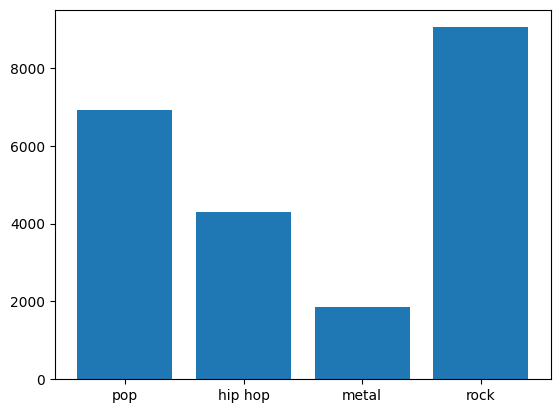

In [54]:
plt.bar(q11.toPandas()['genre'],q11.toPandas()['count'])